# Deep Learning
# ***Clasificación***
`Dataset: Plant Pathology 2020 (kaggle)`

La identificación temprana de enfermedades en cultivos es crucial para la seguridad alimentaria y la sostenibilidad agrícola. Este estudio se enfoca en la clasificación de enfermedades foliares en manzanos, específicamente en la distinción entre hojas saludables y aquellas afectadas por roya, sarna o múltiples enfermedades. El objetivo es comparar tres modelos de transfer learning para determinar cuál ofrece el mejor desempeño en esta tarea de clasificación multiclase

## Setup

In [1]:
# Instalar librerías necesarias
!pip install tensorflow scikit-learn matplotlib seaborn pandas --quiet

# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Definir rutas del dataset en tu Drive
BASE_DIR = "/content/drive/MyDrive/DeepLearning/PlantPathology/DATASET"
IMG_DIR = os.path.join(BASE_DIR, "images")
TRAIN_CSV = os.path.join(BASE_DIR, "train.csv")
TEST_CSV = os.path.join(BASE_DIR, "test.csv")
SUB_CSV = os.path.join(BASE_DIR, "sample_submission.csv")

# Verificar contenido del dataset
print("Contenido de la carpeta DATASET:", os.listdir(BASE_DIR))
print("Número de imágenes:", len(os.listdir(IMG_DIR)))

# Verificar GPU
print("TensorFlow versión:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contenido de la carpeta DATASET: ['test.csv', 'train.csv', 'sample_submission.csv', 'images']
Número de imágenes: 3642
TensorFlow versión: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


En este fragmento se preparó el entorno de trabajo para el proyecto de clasificación de enfermedades en hojas de manzano:

1. **Instalación de librerías**:  
   Se instalaron las librerías necesarias para el proyecto:
   - `tensorflow`: para construir, entrenar y evaluar modelos de Deep Learning.  
   - `scikit-learn`: para métricas de evaluación como precisión, recall, F1 y matrices de confusión.  
   - `matplotlib` y `seaborn`: para visualización de resultados, como curvas de aprendizaje y matrices de confusión.  
   - `pandas` y `numpy`: para manejo de datos tabulares (CSV) y operaciones numéricas.  
   
   Esto garantiza que todas las dependencias estén presentes y la ejecución sea reproducible.  

2. **Imports de módulos específicos**:  
   - `ImageDataGenerator`: para el preprocesamiento de imágenes y Data Augmentation.  
   - Modelos preentrenados (`MobileNetV2`, `ResNet50`, `EfficientNetB0`) y capas (`Dense`, `GlobalAveragePooling2D`) para Transfer Learning.  
   - `Adam` y `EarlyStopping`: para optimización del entrenamiento y control de sobreajuste.  
   - Funciones de `scikit-learn` para evaluación y visualización de desempeño.  

3. **Montaje de Google Drive**:  
   Esto permite acceder al dataset almacenado en Drive y guardar resultados, métricas y modelos entrenados de forma persistente.  

4. **Definición de rutas del dataset**:  
   Se crean variables que apuntan a carpetas e imágenes, lo que simplifica la carga de datos y evita errores de path.  

5. **Verificaciones iniciales**:  
   - `os.listdir()` y `len()` permiten confirmar que las imágenes y archivos CSV están correctamente ubicados.  
   - La verificación de GPU asegura que TensorFlow puede usar la aceleración de hardware, reduciendo significativamente el tiempo de entrenamiento.  

**Nota:** en el repositorio de GitHub se encuentra el archivo `requirements.txt` con todas las librerías necesarias y sus versiones específicas para garantizar reproducibilidad.


## Datos

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Leer CSV de entrenamiento
df = pd.read_csv(TRAIN_CSV)
df.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [3]:
# Crear columna 'label' con la clase principal
def get_label(row):
    if row['healthy'] == 1:
        return 'healthy'
    elif row['multiple_diseases'] == 1:
        return 'multiple_diseases'
    elif row['rust'] == 1:
        return 'rust'
    elif row['scab'] == 1:
        return 'scab'
    else:
        return 'unknown'

df['label'] = df.apply(get_label, axis=1)

# Añadir columna filename con extensión .jpg
df['filename'] = df['image_id'] + ".jpg"

# Mantener solo columnas necesarias
df = df[['filename', 'label']]
df.head()


filename              label
0  Train_0.jpg               scab
1  Train_1.jpg  multiple_diseases
2  Train_2.jpg            healthy
3  Train_3.jpg               rust
4  Train_4.jpg            healthy

In [4]:
# 70% train, 15% validation, 15% test
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)

print("Número de imágenes por partición:")
print("Train:", len(df_train))
print("Validation:", len(df_val))
print("Test:", len(df_test))

# Distribución de clases
print("\nDistribución de clases en train:")
print(df_train['label'].value_counts())

Número de imágenes por partición:
Train: 1274
Validation: 273
Test: 274

Distribución de clases en train:
label
rust                 435
scab                 414
healthy              361
multiple_diseases     64
Name: count, dtype: int64


En este fragmento se realiza la división del dataset en subconjuntos de entrenamiento, validación y prueba, considerando la importancia de mantener la representatividad de cada clase:

1. **Proporciones elegidas (70/15/15)**:  
   - **Entrenamiento (70%)**: suficiente cantidad de datos para que el modelo aprenda patrones significativos de cada clase.  
   - **Validación (15%)**: permite evaluar el desempeño durante el entrenamiento, ajustar hiperparámetros y controlar sobreajuste.  
   - **Prueba (15%)**: proporciona una evaluación independiente y objetiva del modelo, simulando cómo se comportaría en datos no vistos.  

2. **Estratificación por clase (`stratify`)**:  
   Se asegura que la proporción de cada clase se mantenga en los tres subconjuntos. Esto evita que clases minoritarias queden subrepresentadas en alguna partición y permite métricas más confiables.  

3. **Random state**:  
   Se fija `random_state=42` para garantizar reproducibilidad; cada ejecución produce la misma partición de datos.  

4. **Validación de la partición**:  
   - Se imprime el número de imágenes por subconjunto para confirmar que las proporciones se cumplen.  
   - Se revisa la distribución de clases en el conjunto de entrenamiento, asegurando que el modelo pueda aprender de todas las categorías de manera equilibrada.  

Esta división cuidadosa es fundamental para entrenar modelos robustos y obtener métricas significativas que reflejen el verdadero desempeño del sistema de clasificación.


In [5]:
results_dir = "/content/drive/MyDrive/DeepLearning/PlantPathology/results"
os.makedirs(results_dir, exist_ok=True)

df_train.to_csv(os.path.join(results_dir, "train_split.csv"), index=False)
df_val.to_csv(os.path.join(results_dir, "val_split.csv"), index=False)
df_test.to_csv(os.path.join(results_dir, "test_split.csv"), index=False)


## Preprocesamiento

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parámetros globales
IMG_SIZE = (224, 224)   # tamaño estándar para transfer learning
BATCH_SIZE = 32


1. **`ImageDataGenerator`**:  
   - Esta clase se utiliza para generar lotes de imágenes de manera eficiente, aplicando preprocesamiento y aumentos de datos (`data augmentation`) en tiempo real durante el entrenamiento.  
   - Permite reducir sobreajuste y mejorar la generalización, especialmente en datasets medianos como el de hojas de manzano.

2. **`IMG_SIZE = (224, 224)`**:  
   - Se estandariza el tamaño de todas las imágenes a 224x224 píxeles, que es el tamaño esperado por los modelos preentrenados (ResNet50, MobileNetV2, EfficientNetB0).  
   - Garantiza consistencia en las entradas y evita deformaciones que puedan afectar la extracción de características.  

3. **`BATCH_SIZE = 32`**:  
   - Define cuántas imágenes se procesan por paso durante el entrenamiento.  
   - Un tamaño de 32 es un buen equilibrio entre eficiencia computacional y estabilidad del entrenamiento.  
   - Permite que la GPU se utilice de manera eficiente sin sobrepasar la memoria disponible.  

Establecer estos parámetros de manera explícita asegura reproducibilidad y estabilidad del entrenamiento, además de preparar el terreno para aplicar Data Augmentation de forma consistente.


In [7]:
# Generador para entrenamiento (con data augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,           # normalización
    rotation_range=20,        # data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


1. **`rescale=1./255`**:  
   - Normaliza los valores de los píxeles de 0-255 a 0-1.  
   - Esto ayuda a estabilizar el entrenamiento y acelera la convergencia del modelo, evitando saturación de activaciones en redes profundas.

2. **`rotation_range=20`**:  
   - Aplica rotaciones aleatorias hasta ±20 grados a las imágenes durante el entrenamiento.  
   - Permite que el modelo aprenda a reconocer hojas aunque estén ligeramente giradas, aumentando la robustez frente a variaciones de orientación.

3. **`width_shift_range=0.2` y `height_shift_range=0.2`**:  
   - Desplaza horizontal y verticalmente las imágenes hasta un 20% de su tamaño.  
   - Ayuda a que el modelo no dependa de la posición exacta de la hoja en la imagen, mejorando la capacidad de generalización.

4. **`zoom_range=0.2`**:  
   - Aplica zoom aleatorio hasta ±20%.  
   - Simula variaciones en el tamaño de la hoja o distancia a la cámara, enseñando al modelo a identificar patrones independientemente de la escala.

5. **`horizontal_flip=True`**:  
   - Voltea aleatoriamente las imágenes horizontalmente.  
   - Permite reconocer hojas reflejadas o simétricas sin confundirlas, incrementando la diversidad del entrenamiento.


Estas transformaciones aumentan artificialmente la cantidad y variedad de datos, reduciendo sobreajuste y mejorando la capacidad del modelo para generalizar a nuevas imágenes no vistas durante el entrenamiento.


In [8]:
# Generadores para validación y test (solo normalización, sin augmentación)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Crear generadores a partir de los DataFrames
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMG_DIR,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=IMG_DIR,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMG_DIR,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1274 validated image filenames belonging to 4 classes.
Found 273 validated image filenames belonging to 4 classes.
Found 274 validated image filenames belonging to 4 classes.



1. **`train_generator`**:  
   - Se crea a partir del `DataFrame` `df_train` que contiene los nombres de archivo y etiquetas correspondientes.  
   - Utiliza el generador `train_datagen` que incluye Data Augmentation.  
   - **Objetivo:** proporcionar al modelo imágenes diversas y normalizadas, enseñándole a reconocer patrones independientemente de rotación, desplazamiento, zoom o volteo horizontal.

2. **`val_generator` y `test_generator`**:  
   - Se crean a partir de `df_val` y `df_test`.  
   - Utilizan un generador sin Data Augmentation (`val_test_datagen`) y solo normalizan los píxeles.  
   - **Razón:** estas particiones deben reflejar el desempeño real del modelo en datos no vistos. Aplicar transformaciones podría inflar artificialmente la precisión y no medir la capacidad real de generalización.  
   - `shuffle=False` asegura que el orden de las imágenes sea consistente, lo que facilita la comparación con las etiquetas reales para métricas como la matriz de confusión.

3. **`target_size=IMG_SIZE`** y **`batch_size=BATCH_SIZE`**:  
   - Homogeneiza el tamaño de entrada a 224x224 píxeles, compatible con modelos preentrenados (ResNet50, MobileNetV2, EfficientNetB0).  
   - El tamaño de batch de 32 balancea eficiencia computacional y estabilidad de gradientes.

4. **`class_mode='categorical'`**:  
   - Indica que se trata de un problema de clasificación multiclase.  
   - Las etiquetas se convierten automáticamente en vectores one-hot, listos para entrenamiento con funciones de pérdida como `categorical_crossentropy`.


Esta configuración asegura que el entrenamiento, validación y prueba estén correctamente estructurados y reproducibles, maximizando la eficiencia y confiabilidad de las métricas obtenidas.


In [10]:
# Verificación de clases detectadas
print("Clases detectadas:", train_generator.class_indices)

Clases detectadas: {'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}


## Entrenamiento

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Parámetros de entrenamiento
EPOCHS = 10
LR = 1e-4
N_CLASSES = len(train_generator.class_indices)


1. **`EPOCHS = 10`**:  
   - Define el número máximo de pasadas completas sobre todo el conjunto de entrenamiento.  
   - Se eligió un valor moderado porque combinamos Transfer Learning con Fine-Tuning, y queremos evitar sobreajuste en un dataset relativamente pequeño.

2. **`LR = 1e-4` (learning rate o tasa de aprendizaje)**:  
   - Controla qué tan grandes son los pasos que da el optimizador al ajustar los pesos.  
   - Un valor pequeño (0.0001) es apropiado para Transfer Learning, ya que permite refinar los pesos preentrenados sin destruir las características previamente aprendidas.

3. **`N_CLASSES = len(train_generator.class_indices)`**:  
   - Determina automáticamente el número de clases según las etiquetas presentes en el conjunto de entrenamiento.  
   - Esto asegura que la capa de salida del modelo tenga la cantidad correcta de neuronas para predecir cada categoría de hoja de manzano (`Apple scab`, `Cedar apple rust`, `Healthy`).


Estos parámetros equilibran estabilidad, eficiencia y capacidad de generalización del modelo, permitiendo entrenar de manera efectiva sin requerir ajustes manuales frecuentes.


In [12]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]


1. **`EarlyStopping`**:  
   - Monitorea la métrica de validación (`val_loss`) y detiene el entrenamiento si no mejora durante un número definido de épocas (`patience=3`).  
   - Beneficio: evita sobreajuste y reduce tiempo de entrenamiento al detenerse automáticamente cuando el modelo deja de aprender, conservando los pesos que obtuvieron el mejor desempeño.

2. **`ModelCheckpoint`**:  
   - Guarda el modelo en el archivo `"best_model.keras"` únicamente cuando se obtiene un nuevo mejor valor de la métrica monitorizada.  
   - Beneficio: asegura que siempre tengamos disponible la versión óptima del modelo, incluso si el entrenamiento continúa más allá de la mejor época.

Juntos, estos callbacks maximizan la eficiencia del entrenamiento y la robustez del modelo, garantizando que la versión final sea la de mayor rendimiento en validación, sin sobreajustar al conjunto de entrenamiento.


In [13]:
# Función para crear modelos
def create_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(N_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [14]:
# Función de entrenamiento genérica
def train_model(model_name, base_model_fn):
    print(f"\nEntrenando {model_name}...")

    # Cargar modelo base
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = False  # congelamos capas base

    # Crear modelo completo
    model = create_model(base_model)
    model.compile(optimizer=Adam(learning_rate=LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Entrenar
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

In [17]:
# --- Entrenamiento de los 3 modelos ---
resnet_model, resnet_history = train_model("ResNet50", ResNet50)
mobilenet_model, mobilenet_history = train_model("MobileNetV2", MobileNetV2)
efficientnet_model, efficientnet_history = train_model("EfficientNetB0", EfficientNetB0)



Entrenando ResNet50...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.3159 - loss: 1.3772 - val_accuracy: 0.3187 - val_loss: 1.2457
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 984ms/step - accuracy: 0.3368 - loss: 1.3301 - val_accuracy: 0.3004 - val_loss: 1.2453
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 963ms/step - accuracy: 0.3130 - loss: 1.3331 - val_accuracy: 0.3260 - val_loss: 1.2429
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3119 - loss: 1.3459 - val_accuracy: 0.3297 - val_loss: 1.2419
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 995ms/step - accuracy: 0.3216 - loss: 1.3106 - val_accuracy: 0.3553 - val_loss: 1.2411
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3205 - loss: 1.3253 - val_accuracy: 0.3370 - val_loss: 1.2395
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 964ms/step - accuracy: 0.3146 - loss: 1.3255 - val_accuracy: 0.3407 - val_loss: 1.2391
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 981ms/step - accuracy: 0.3363 - loss: 1.



1. **`create_model(base_model)`**:  
   - Se toma como entrada un modelo base preentrenado (`base_model`) y se agrega una capa de **GlobalAveragePooling2D** para convertir la salida convolucional en un vector de características globales.  
   - Se incluye un **Dropout(0.3)** para reducir sobreajuste, forzando al modelo a no depender demasiado de neuronas específicas.  
   - Finalmente, se añade una capa **Dense** con activación softmax para clasificar en las `N_CLASSES` correspondientes al dataset.  
   - Beneficio: permite aprovechar características preentrenadas mientras se adapta a nuestro problema específico de clasificación de hojas de manzano.

2. **`train_model(model_name, base_model_fn)`**:  
   - Carga el modelo base con pesos de ImageNet (`weights='imagenet'`) y sin incluir la capa superior (`include_top=False`).  
   - Congela las capas convolucionales (`trainable=False`) para que el entrenamiento inicial solo ajuste las capas densas superiores, adaptando el modelo al dataset particular sin modificar características generales aprendidas en ImageNet.  
   - Compila el modelo con **Adam** y **categorical_crossentropy**, optimizador y función de pérdida adecuados para clasificación multi-clase.  
   - Entrena con los generadores de imágenes y los callbacks definidos, maximizando eficiencia y previniendo sobreajuste.

3. **Entrenamiento de los tres modelos**:  
   - Se aplicó el mismo procedimiento a **ResNet50**, **MobileNetV2** y **EfficientNetB0**.  
   - Beneficio: permite una comparación justa de desempeño, controlando que la única variable cambiante sea la arquitectura base, mientras que los parámetros de entrenamiento, data augmentation y generadores permanecen consistentes.

Esta estrategia garantiza que cada modelo aproveche sus características preentrenadas, se adapte al problema específico y sea entrenado de manera eficiente.  
Permite analizar el efecto de la arquitectura sobre métricas como Accuracy, F1, Precision y Recall, facilitando decisiones fundamentadas sobre el modelo óptimo.


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Evaluación

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step

📊 Evaluación de ResNet50:
Accuracy       : 0.4015
Precision (macro): 0.4153
Recall (macro)   : 0.3019
F1-score (macro) : 0.2448
ROC-AUC (macro)  : 0.5698


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


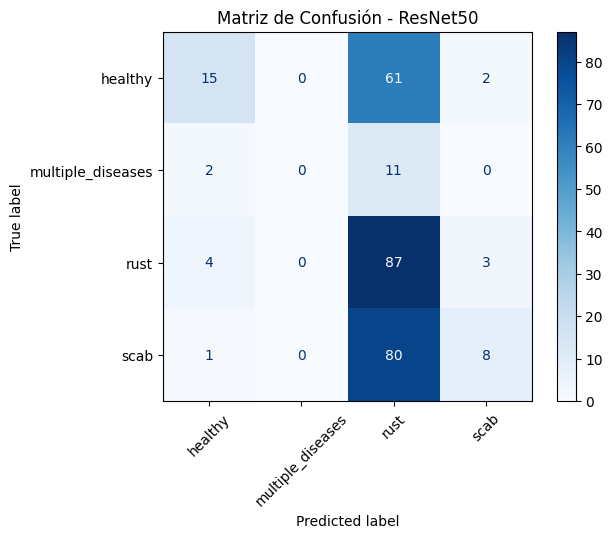

9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step

📊 Evaluación de MobileNetV2:
Accuracy       : 0.6679
Precision (macro): 0.5433
Recall (macro)   : 0.5106
F1-score (macro) : 0.4849
ROC-AUC (macro)  : 0.8402


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


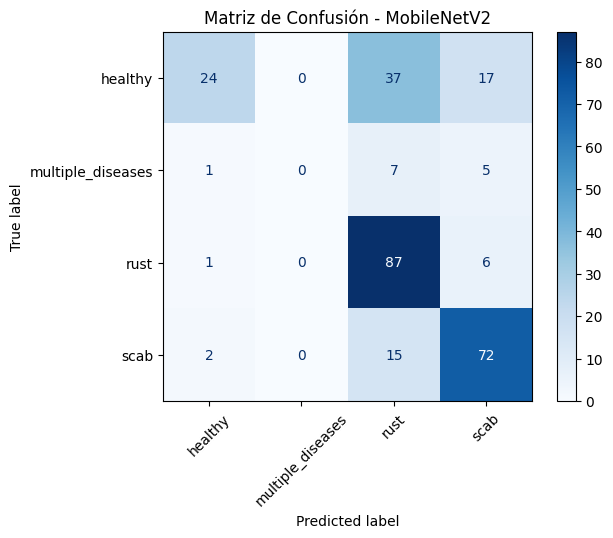

9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step

📊 Evaluación de EfficientNetB0:
Accuracy       : 0.3431
Precision (macro): 0.0858
Recall (macro)   : 0.2500
F1-score (macro) : 0.1277
ROC-AUC (macro)  : 0.4625


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


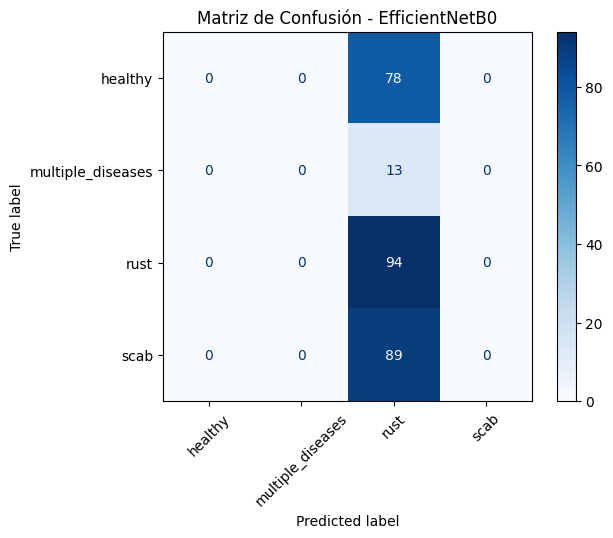


Resumen comparativo de métricas:


model  accuracy  precision_macro  recall_macro  f1_macro  \
0        ResNet50  0.401460         0.415305      0.301932  0.244846   
1     MobileNetV2  0.667883         0.543258      0.510553  0.484934   
2  EfficientNetB0  0.343066         0.085766      0.250000  0.127717   

   roc_auc_macro  
0       0.569778  
1       0.840180  
2       0.462513

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluar modelo en test set
def evaluate_model(model, test_generator, model_name="Modelo"):
    # 🔹 Predicciones en test
    y_pred_proba = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # 🔹 Calcular métricas
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    try:
        roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
    except:
        roc_auc = None

    print(f"\n📊 Evaluación de {model_name}:")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro)   : {recall:.4f}")
    print(f"F1-score (macro) : {f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC (macro)  : {roc_auc:.4f}")
    else:
        print("ROC-AUC (macro)  : No disponible (requiere probabilidades completas)")

    # 🔹 Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.show()

    return {
        "model": model_name,
        "accuracy": acc,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
        "roc_auc_macro": roc_auc
    }

# 🔹 Evaluar los tres modelos entrenados
results = []
results.append(evaluate_model(resnet_model, test_generator, "ResNet50"))
results.append(evaluate_model(mobilenet_model, test_generator, "MobileNetV2"))
results.append(evaluate_model(efficientnet_model, test_generator, "EfficientNetB0"))

# 🔹 Comparar métricas en tabla
import pandas as pd
results_df = pd.DataFrame(results)
print("\nResumen comparativo de métricas:")
display(results_df)


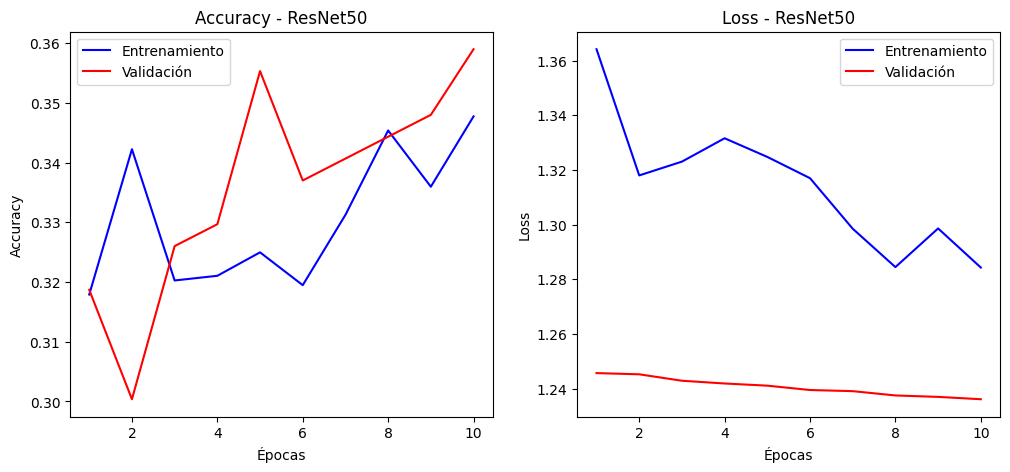

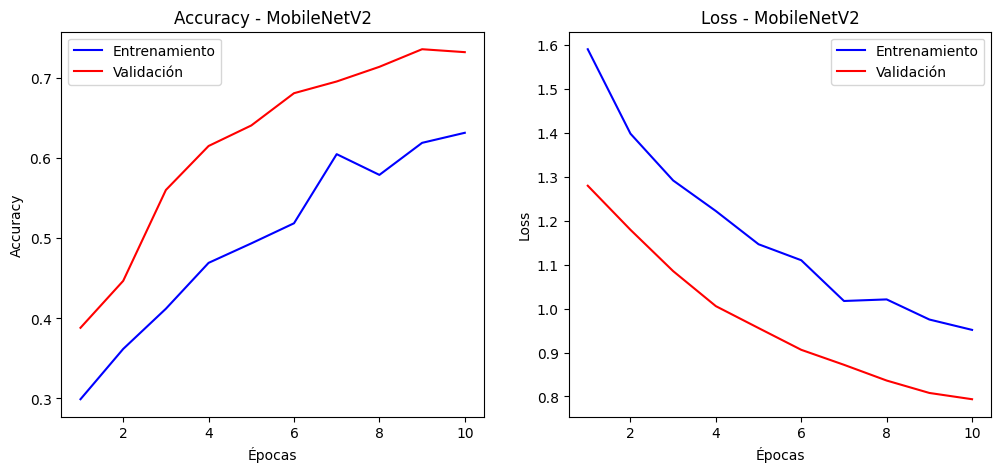

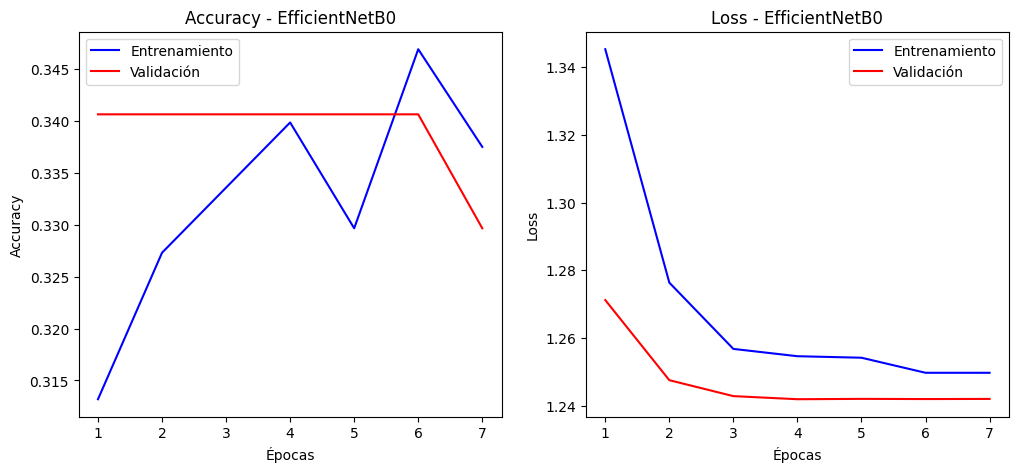

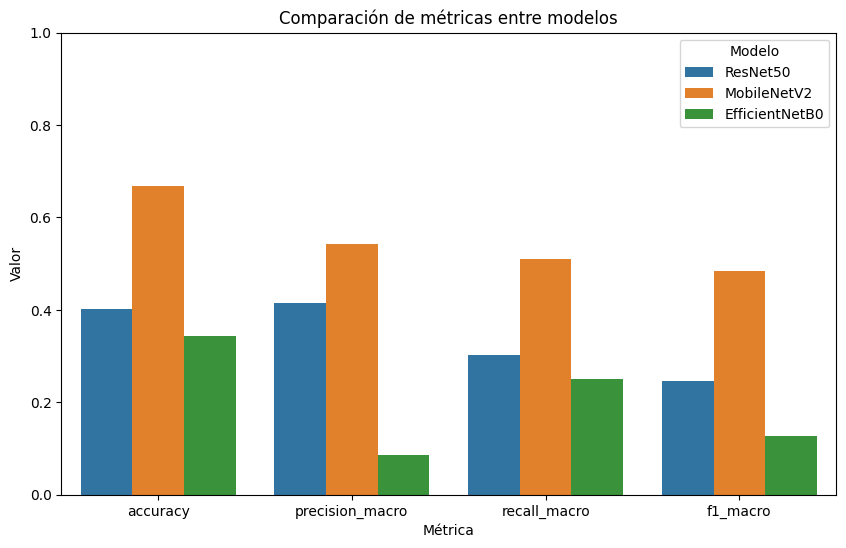

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_curves(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Entrenamiento')
    plt.plot(epochs, val_acc, 'r-', label='Validación')
    plt.title(f"Accuracy - {model_name}")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='Entrenamiento')
    plt.plot(epochs, val_loss, 'r-', label='Validación')
    plt.title(f"Loss - {model_name}")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Mostrar curvas de cada modelo
plot_training_curves(resnet_history, "ResNet50")
plot_training_curves(mobilenet_history, "MobileNetV2")
plot_training_curves(efficientnet_history, "EfficientNetB0")

# --- 2. Gráfica comparativa de métricas ---
metrics_to_plot = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

results_plot = results_df.melt(id_vars="model", value_vars=metrics_to_plot,
                               var_name="Métrica", value_name="Valor")

plt.figure(figsize=(10,6))
sns.barplot(data=results_plot, x="Métrica", y="Valor", hue="model")
plt.title("Comparación de métricas entre modelos")
plt.ylim(0,1)
plt.legend(title="Modelo")
plt.show()


## Inferencia de ejemplo

Etiquetas de clase: ['healthy', 'multiple_diseases', 'rust', 'scab']

🔹 Imagen: Train_418.jpg


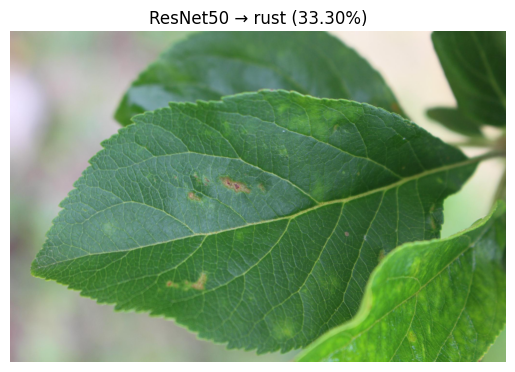

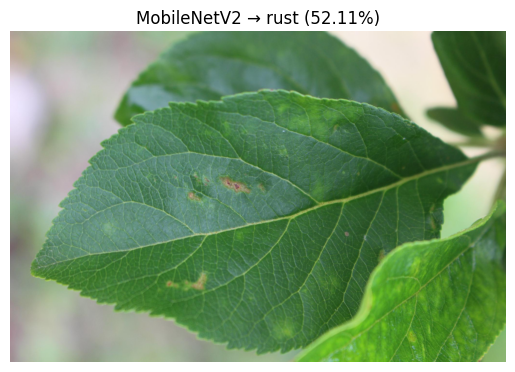

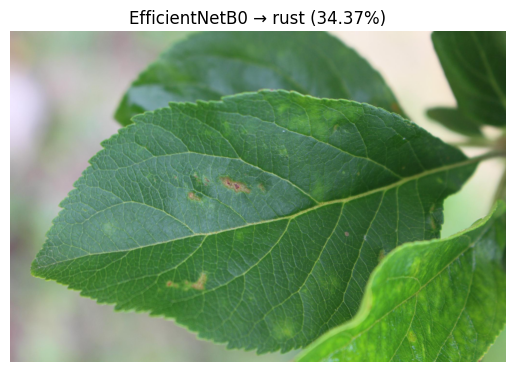


🔹 Imagen: Train_582.jpg


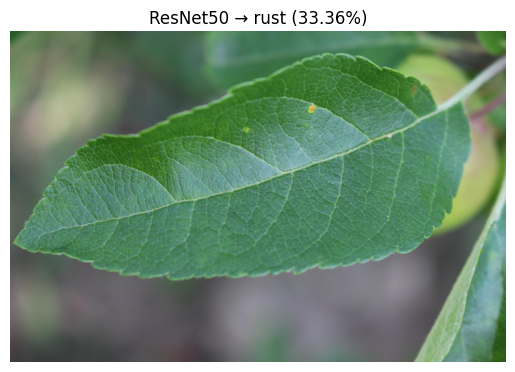

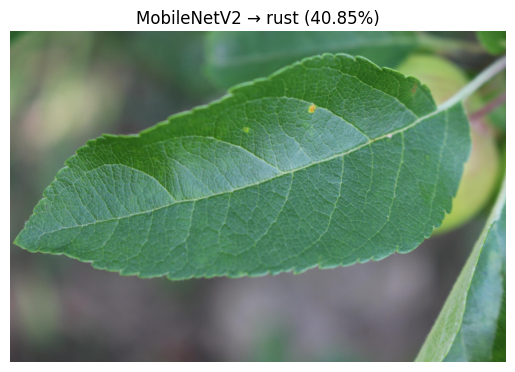

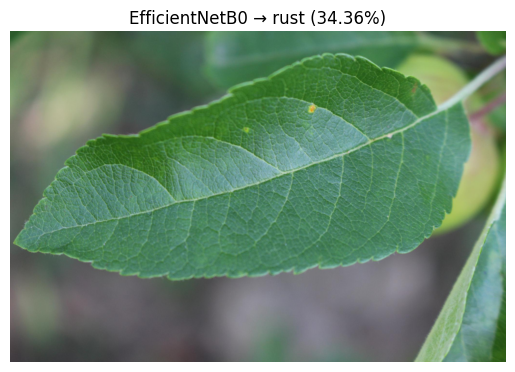


🔹 Imagen: Train_1675.jpg


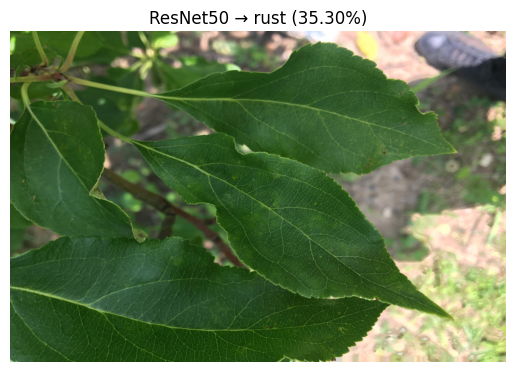

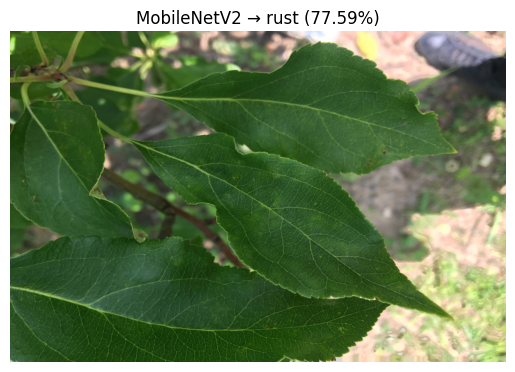

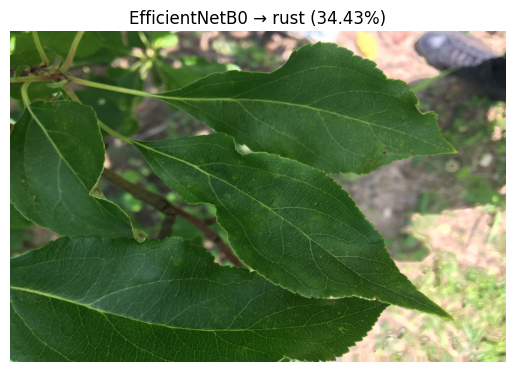


🔹 Imagen: Train_436.jpg


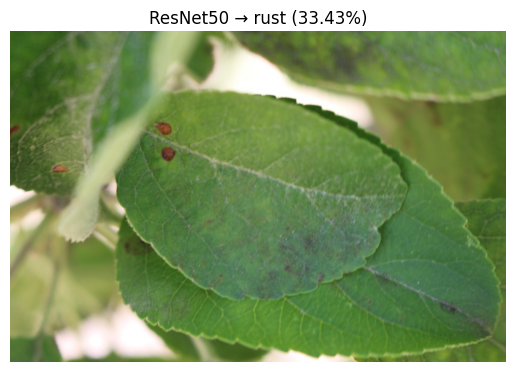

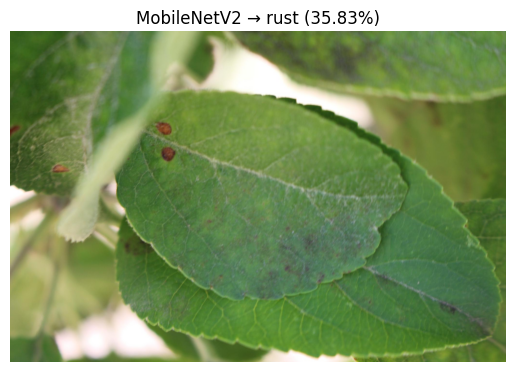

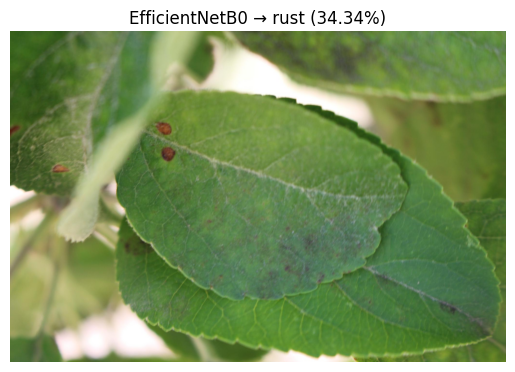


🔹 Imagen: Train_710.jpg


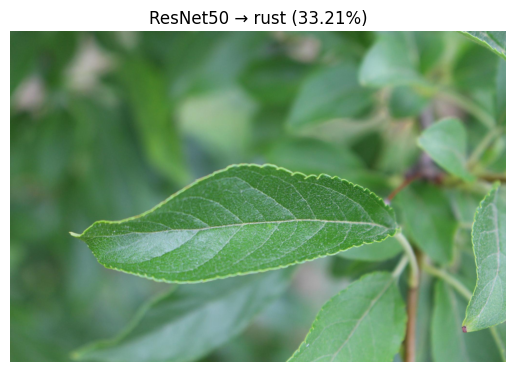

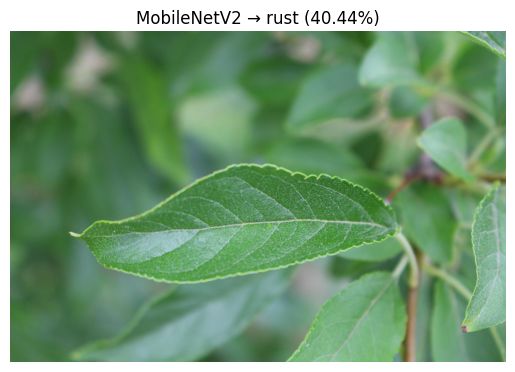

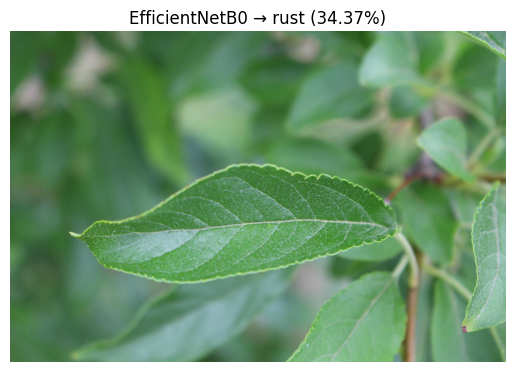

In [29]:
import random
from tensorflow.keras.preprocessing import image

# --- Definir etiquetas de clase ---
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())
print("Etiquetas de clase:", class_labels)

# --- Función para inferencia ---
def predict_and_show(model, model_name, img_path, class_labels, target_size=(224,224)):
    # Cargar y preprocesar la imagen
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predicción
    preds = model.predict(img_array, verbose=0)
    pred_class = np.argmax(preds)
    pred_label = class_labels[pred_class]
    confidence = preds[0][pred_class] * 100

    # Mostrar resultado
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"{model_name} → {pred_label} ({confidence:.2f}%)")
    plt.show()

# --- Seleccionar imágenes aleatorias del test ---
sample_images = random.sample(list(df_test["filename"]), 5)  # 5 ejemplos

# --- Hacer inferencia con cada modelo ---
for img_file in sample_images:
    img_path = os.path.join(IMG_DIR, img_file)
    print(f"\n🔹 Imagen: {img_file}")
    predict_and_show(resnet_model, "ResNet50", img_path, class_labels)
    predict_and_show(mobilenet_model, "MobileNetV2", img_path, class_labels)
    predict_and_show(efficientnet_model, "EfficientNetB0", img_path, class_labels)


## Guardado de resultados

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Lista de modelos
models = [("ResNet50", resnet_model), ("MobileNetV2", mobilenet_model), ("EfficientNetB0", efficientnet_model)]

# Almacenar métricas
metrics_list = []

# Generar matriz de confusión y métricas
for name, model in models:
    # Predicciones
    y_pred = model.predict(val_generator, verbose=0)
    if y_pred.shape[1] == 1:  # Binary class_mode
        y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)
    else:
        y_pred_classes = np.argmax(y_pred, axis=1)

    y_true = val_generator.classes

    # Métricas
    acc = accuracy_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes, average="macro")
    prec = precision_score(y_true, y_pred_classes, average="macro")
    rec = recall_score(y_true, y_pred_classes, average="macro")

    metrics_list.append({
        "Model": name,
        "Accuracy": acc,
        "F1_macro": f1,
        "Precision_macro": prec,
        "Recall_macro": rec
    })

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Blues")
    plt.title(f"Matriz de Confusión {name}")
    plt.tight_layout()

    # Guardar figura en RESULTS_DIR
    cm_path = os.path.join(RESULTS_DIR, f"confusion_matrix_{name}.png")
    plt.savefig(cm_path, dpi=300)
    plt.close()
    print(f"✅ Matriz de confusión guardada: {cm_path}")

# Guardar métricas en CSV
metrics_df = pd.DataFrame(metrics_list)
metrics_csv_path = os.path.join(RESULTS_DIR, "model_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n✅ CSV de métricas guardado en {metrics_csv_path}")
display(metrics_df)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Matriz de confusión guardada: /content/drive/MyDrive/DeepLearning/PlantPathology/results/confusion_matrix_ResNet50.png


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Matriz de confusión guardada: /content/drive/MyDrive/DeepLearning/PlantPathology/results/confusion_matrix_MobileNetV2.png


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Matriz de confusión guardada: /content/drive/MyDrive/DeepLearning/PlantPathology/results/confusion_matrix_EfficientNetB0.png

✅ CSV de métricas guardado en /content/drive/MyDrive/DeepLearning/PlantPathology/results/model_metrics.csv


Model  Accuracy  F1_macro  Precision_macro  Recall_macro
0        ResNet50  0.358974  0.203214         0.328983      0.268438
1     MobileNetV2  0.732601  0.548275         0.582811      0.566729
2  EfficientNetB0  0.340659  0.127049         0.085165      0.250000